In [6]:
# moving the dataset file from google drive to the colab server
!cp /content/drive/MyDrive/Test_workspace/gesture.zip /content/

In [8]:
# moving the model file from google drive to the colab server
!cp /content/drive/MyDrive/Test_workspace/model_007_Adam.h5 /content/

In [7]:
# unzipped the compressed file
import zipfile
import os
files = zipfile.ZipFile('gesture.zip', 'r')
files.extractall(os.getcwd())

In [5]:
# mount the google drive on the colab server
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras

     |████████████████████████████████| 1.3 MB 4.9 MB/s 


In [9]:
"""
Train a CNN with the created dataset
"""

# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, \
    Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD # optimizers and layers should 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

import numpy as np
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action="ignore", category=FutureWarning)


# First, load the data using ImageDataGenerator of keras through which we can use the 
# flow_from_directory to load the train and test set data, and each name of the number folders
# will be the category names for the images loaded
train_path = './gesture/train'
test_path = './gesture/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).\
                              flow_from_directory(directory=train_path,
                              target_size=(64,64),
                              class_mode='categorical',
                              batch_size=10,
                              shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).\
                              flow_from_directory(directory=test_path,
                              target_size=(64,64),
                              class_mode='categorical',
                              batch_size=10,
                              shuffle=True)

Found 7020 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

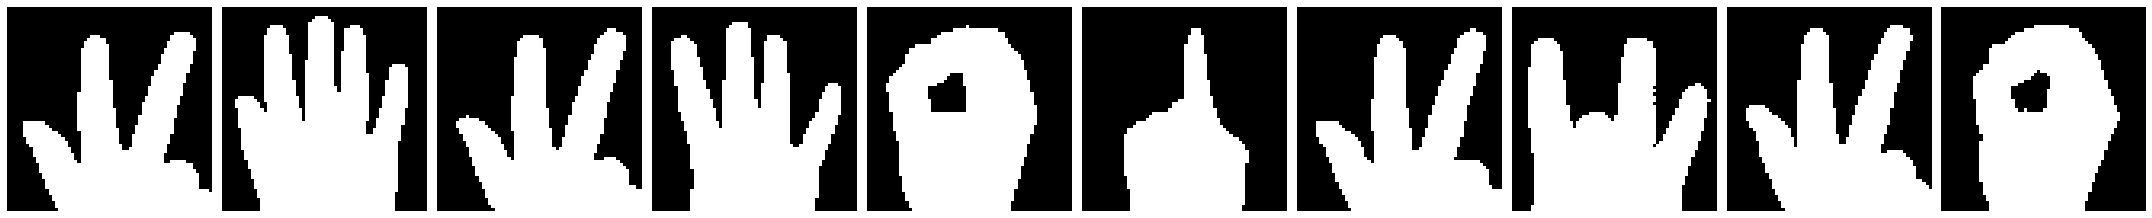

(10, 64, 64, 3)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
# Return the next item of the iterator for demo display
imgs, labels = next(train_batches)

# Plot the images
def plot_images(images_arr):
    # Create a 1 cross 10 figure with 10 subfigures
    fig, axes = plt.subplots(1, 10, figsize=(30, 20))
    # Convert handle array axes into an one-dimensional array 
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # Alter the color channel's order in the image 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Display the image
        ax.imshow(img)
        ax.axis('off')
    # Regularize the layout of subfigures
    plt.tight_layout()
    plt.show()

plot_images(imgs)
print(imgs.shape)
print(labels)

In [ ]:
# Design a CNN as follows
model = Sequential()

# The input size of network is the size of the image: 64 x 64 x 3
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# Fully-connected layers
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

In [ ]:
"""
The programs below contains two different optimization algorithms
SGD (stochastic gradient descent, that means the weights are updated at every training instance)
Adam(combination of Adagrad and RMSProp: more progress will be made when the convergence point
reaches where the parameter space is flatter)

After every epoch, the accuracy and loss are calculated with the validation dataset. 
If the validation loss is not decreasing, the LR of the model will be reduced with ReduceLR
to prevent the model from overshooting the minima of loss. The earlystopping algorithm will
stop the training when the validation accuracy keeps on decreasing.

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
"""
# factor: how much the learning rate decreased at each epoch
# min_lr: the bottom limit of LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
# create another checkpoint to save the best model
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',monitor='val_loss', 
                verbose=0, save_best_only=True, mode='auto')
model.compile(optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
# After compiling the model, the model will be fit on the training batches for 10 epoches
# Use SGD optimizer for training
training_history = model.fit_generator(train_batches, epochs=80,
                    callbacks=[reduce_lr, checkpoint],
                    validation_data=test_batches,
                    steps_per_epoch=7020//(train_batches.batch_size*25))
# validation_steps=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/80
28/28 [==============================] - 5s 133ms/step - loss: 7.7745 - accuracy: 0.1321 - val_loss: 2.1084 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 2/80
28/28 [==============================] - 3s 126ms/step - loss: 1.9666 - accuracy: 0.2786 - val_loss: 1.9220 - val_accuracy: 0.3366 - lr: 0.0010
Epoch 3/80
28/28 [==============================] - 4s 127ms/step - loss: 1.7572 - accuracy: 0.3750 - val_loss: 1.7320 - val_accuracy: 0.4049 - lr: 0.0010
Epoch 4/80
28/28 [==============================] - 3s 126ms/step - loss: 1.3827 - accuracy: 0.5179 - val_loss: 1.3140 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 5/80
28/28 [==============================] - 4s 127ms/step - loss: 0.9845 - accuracy: 0.6786 - val_loss: 1.2271 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 6/80
28/28 [==============================] - 4s 126ms/step - loss: 0.7087 - accuracy: 0.7607 - val_loss: 1.1365 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 7/80
28/28 [==============================] - 4s 126ms/step - lo

In [ ]:
# After compiling the model, the model will be fit on the training batches for 10 epoches
# Use Adam optimizer for training, its convergence speed is faster than the SGD optimizer
training_history = model.fit_generator(train_batches, epochs=50,
                    callbacks=[reduce_lr, checkpoint],
                    validation_data=test_batches,
                    steps_per_epoch=7020//(train_batches.batch_size*25))
# validation_steps=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
28/28 [==============================] - 5s 142ms/step - loss: 6.0641 - accuracy: 0.1643 - val_loss: 2.0797 - val_accuracy: 0.1537 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 3s 124ms/step - loss: 1.9033 - accuracy: 0.2571 - val_loss: 1.6197 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 3s 126ms/step - loss: 1.3301 - accuracy: 0.5036 - val_loss: 1.4574 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 3s 125ms/step - loss: 0.7924 - accuracy: 0.6893 - val_loss: 1.1685 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 3s 123ms/step - loss: 0.3994 - accuracy: 0.8464 - val_loss: 0.4537 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - 3s 122ms/step - loss: 0.1384 - accuracy: 0.9607 - val_loss: 1.3990 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 7/50
28/28 [==============================] - 4s 127ms/step - lo

In [ ]:
train_batches.class_indices.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [10]:
# Visualizing and making a small test on the model to check if everything is working as we except it to while
# detecting on the live cam feed

# Word_dict is the dictionary containing label names for the various labels predicted
word_dict = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine'}

# Load the model
model = load_model('model_007_Adam.h5')
# For getting next batch of testing images...
imgs, labels = next(test_batches)

# the variable scores contains two parts, the first is the model's loss on the testing dataset,
# the second one is the model's accuracy on the testing dataset
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 0.21989905834197998; accuracy of 89.99999761581421%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

predictions on a small set of test data--

Three  Five  Three  Four  Zero  One  Three  Eight  Three  Zero  

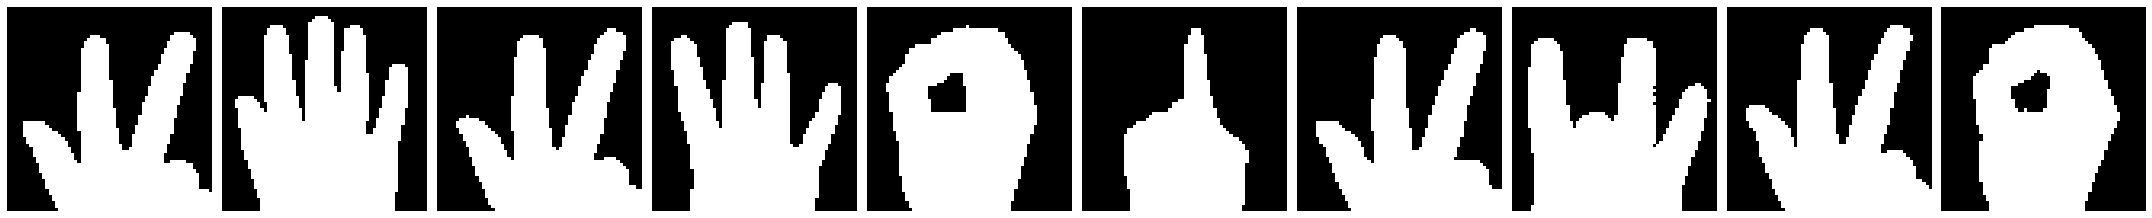

Actual labels
Three  Five  Three  Four  Zero  One  Three  Eight  Three  Zero  

In [13]:
# making predictions to the a small set of test data
predictions = model.predict(imgs, verbose=0)
print("predictions on a small set of test data--")
print("")
# output the prediction label results
for ind, i in enumerate(predictions):
  print(word_dict[np.argmax(i)], end='  ')

plot_images(imgs)
# output the actual labels of these samples
print('Actual labels')
for i in labels:
  print(word_dict[np.argmax(i)], end='  ')